In [15]:
%matplotlib inline
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from scipy.optimize import minimize

import astropy.units as u

import pandas as pd
import exoplanet as xo

from astropy.io import fits
from astropy.table import Table

from flareTools import FINDflare, id_segments, EasyE
from flarePipeline import vetFlare

import matplotlib as mpl
mpl.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix',
                            'image.cmap': 'viridis'})

In [16]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/gj1243/'
#path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec14to17/'

# Lots of flare detections towards the end
# Looks like the ones toward the beginning got missed
# This gets much better if we drop the CPA parameters to 3, 1, 3
f1 = 'tess2018206045859-s0001-0000000079403675-0120-s_lc.fits'

f2 = 'tess2019112060037-s0011-0000000121196226-0143-s_lc.fits'

f3 = 'tess2018206045859-s0001-0000000212262797-0120-s_lc.fits'

# Looks like a couple of strong flares are being missed?
# Its because I masked out this region of the LC
f4 = 'tess2018206045859-s0001-0000000266997586-0120-s_lc.fits'

# Lots of flares, why are some missed?
f5 = 'tess2018234235059-s0002-0000000102032397-0121-s_lc.fits'

# Looks like a big flare, but bad fit. Did the GP have trouble here?
f6 = 'tess2018349182459-s0006-0000000219423316-0126-s_lc.fits'

# Why did the GP fail here?
f6 = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'
f6 = 'tess2019226182529-s0015-0000000273589987-0151-s_lc.fits'

f6 = 'tess2018292075959-s0004-0000000168850387-0124-s_lc.fits'

f6 = 'tess2018319095959-s0005-0000000043472154-0125-s_lc.fits'
f6 = 'tess2018263035959-s0003-0000000207176480-0123-s_lc.fits'
#f6 = 'tess2018292075959-s0004-0000000088405858-0124-s_lc.fits'
#f6 = 'tess2019032160000-s0008-0000000312025443-0136-s_lc.fits'

#f6 = 'tess2018234235059-s0002-0000000332487879-0121-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits' # GJ 1243

#f6 = 'tess2019198215352-s0014-0000000027778168-0150-s_lc.fits'

# Sec 14 and 15 fast rotators from Tyler's kepler-tess crossmatch

# < 0.5 d
#f6 = 'tess2019198215352-s0014-0000000184419029-0150-s_lc.fits' # Noise
#f6 = 'tess2019198215352-s0014-0000000416266231-0150-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000027533798-0150-s_lc.fits' # Noise
#f6 = 'tess2019198215352-s0014-0000000164654552-0150-s_lc.fits' # Noise

# < 1 d
#f6 = 'tess2019198215352-s0014-0000000027843903-0150-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits' # Flares! (GJ 1243)
#f6 = 'tess2019198215352-s0014-0000000351910775-0150-s_lc.fits' # Fast rotator, then noise after the mid-gap?
#f6 = 'tess2019198215352-s0014-0000000377782358-0150-s_lc.fits'
#f6 = 'tess2019198215352-s0014-0000000027843903-0150-s_lc.fits'

#path = 'test_files/'
f6 = 'tess2018206045859-s0001-0000000029779873-0120-s_lc.fits'
f6 = 'tess2019169103026-s0013-0000000040278737-0146-s_lc.fits'
f6 = 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits' # Flares! (GJ 1243)

#f6 = 'tess2018292075959-s0004-0000000308663687-0124-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

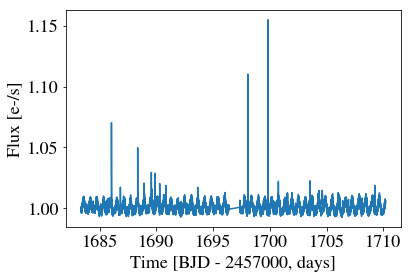

In [17]:
with fits.open(path+f6, mode='readonly') as hdulist:
    #print(hdulist[1].header)
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
mask = (tess_quality == 0) & (~np.isnan(tess_bjds))

time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
median = np.nanmedian(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux/median)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')
#plt.xlim(1624.8,1628)

In [18]:
acf = xo.autocorr_estimator(time, flux/median,
                        yerr=error/median,
                        min_period=0.1, max_period=27, max_peaks=2)

if len(acf['peaks']) > 0:
    acf_1dt = acf['peaks'][0]['period']
    mask = np.where((acf['autocorr'][0] == acf['peaks'][0]['period']))[0]
    acf_1pk = acf['autocorr'][1][mask][0]
    s_window = int(acf_1dt/np.fabs(np.nanmedian(np.diff(time))) / 6)
else:
    acf_1dt = (time[-1] - time[0])/2
    s_window = 128

In [19]:
acf_1dt

0.5923619505169881

In [20]:
class MixtureOfSHOsTerm(terms.SHOTerm):
    parameter_names = ("log_a", "log_Q1", "mix_par", "log_Q2", "log_P")

    def get_real_coefficients(self, params):
        return np.empty(0), np.empty(0)

    def get_complex_coefficients(self, params):
        log_a, log_Q1, mix_par, log_Q2, log_period = params

        Q = np.exp(log_Q2) + np.exp(log_Q1)
        log_Q1 = np.log(Q)
        P = np.exp(log_period)
        log_omega1 = np.log(4*np.pi*Q) - np.log(P) - 0.5*np.log(4.0*Q*Q-1.0)
        log_S1 = log_a - log_omega1 - log_Q1

        mix = -np.log(1.0 + np.exp(-mix_par))
        Q = np.exp(log_Q2)
        P = 0.5*np.exp(log_period)
        log_omega2 = np.log(4*np.pi*Q) - np.log(P) - 0.5*np.log(4.0*Q*Q-1.0)
        log_S2 = mix + log_a - log_omega2 - log_Q2

        c1 = super(MixtureOfSHOsTerm, self).get_complex_coefficients([
            log_S1, log_Q1, log_omega1,
        ])

        c2 = super(MixtureOfSHOsTerm, self).get_complex_coefficients([
            log_S2, log_Q2, log_omega2,
        ])

        return [np.array([a, b]) for a, b in zip(c1, c2)]

    def log_prior(self):
        lp = super(MixtureOfSHOsTerm, self).log_prior()
        if not np.isfinite(lp):
            return -np.inf
        mix = 1.0 / (1.0 + np.exp(-self.mix_par))
        return lp + np.log(mix) + np.log(1.0 - mix)

def get_basic_kernel(t, y, yerr):
    kernel = terms.SHOTerm(
        log_S0=np.log(np.var(y)),
        log_Q=-np.log(4.0),
        log_omega0=np.log(2*np.pi/10.),
        bounds=dict(
            log_S0=(-20.0, 10.0),
            log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0)),
        ),
    )
    kernel.freeze_parameter('log_Q')

    # Finally some jitter
    kernel += terms.JitterTerm(log_sigma=np.log(np.median(yerr)),
                               bounds=[(-20.0, 5.0)])

    return kernel

def get_rotation_gp(t, y, yerr, period, min_period, max_period):
    kernel = get_basic_kernel(t, y, yerr)
    kernel += MixtureOfSHOsTerm(
        log_a=np.log(np.var(y)),
        log_Q1=np.log(15),
        mix_par=-1.0,
        log_Q2=np.log(15),
        log_P=np.log(period),
        bounds=dict(
            log_a=(-20.0, 10.0),
            log_Q1=(-0.5*np.log(2.0), 11.0),
            mix_par=(-5.0, 5.0),
            log_Q2=(-0.5*np.log(2.0), 11.0),
            log_P=(np.log(min_period), np.log(max_period)),
        )
    )

    gp = celerite.GP(kernel=kernel, mean=0.)
    gp.compute(t)
    return gp

OrderedDict([('kernel:terms[0]:log_S0', 0.9727235552963038), ('kernel:terms[0]:log_omega0', -1.135044289462507), ('kernel:terms[1]:log_sigma', -7.57039042691667), ('kernel:terms[2]:log_a', -15.366995789750165), ('kernel:terms[2]:log_Q1', 2.244371806852667), ('kernel:terms[2]:mix_par', -1.8975513801361479), ('kernel:terms[2]:log_Q2', 3.9701788942723506), ('kernel:terms[2]:log_P', 2.5649493574615367)])
0.483321946706122
2854 3977
OrderedDict([('kernel:terms[0]:log_S0', 1.153880926472493), ('kernel:terms[0]:log_omega0', -1.2679130003174905), ('kernel:terms[1]:log_sigma', -14.446102561869742), ('kernel:terms[2]:log_a', -15.367145219917392), ('kernel:terms[2]:log_Q1', 2.2443718842210756), ('kernel:terms[2]:mix_par', -1.8976091049125896), ('kernel:terms[2]:log_Q2', 3.9701793374543914), ('kernel:terms[2]:log_P', 2.5649493574615367)])
0.483321946706122
2224 2854
OrderedDict([('kernel:terms[0]:log_S0', 1.211897380764413), ('kernel:terms[0]:log_omega0', -1.3104387981429844), ('kernel:terms[1]:lo

KeyboardInterrupt: 

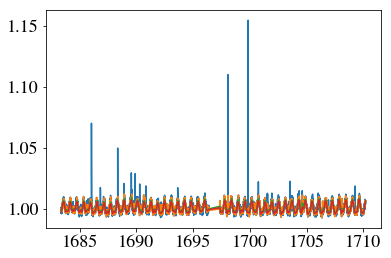

In [28]:
num_iter = 20
n_samp = 4000
max_tries = 1
try_count = 0
period_guess = acf_1dt

x = time
y = flux/median
yerr = error/median

plt.plot(x,y)

while try_count < max_tries:
    try:
        # Randomly select n points from the light curve for the GP fit
        x_ind_rand = np.random.choice(len(x), n_samp, replace=False)
        x_ind = x_ind_rand[np.argsort(x[x_ind_rand])]

        x_gp = x[x_ind]
        y_gp = y[x_ind]
        yerr_gp = yerr[x_ind]

        # Do some aggressive sigma clipping
        m = np.ones(len(x_gp), dtype=bool)
        while True:
            mu = np.mean(y_gp[m])
            sig = np.std(y_gp[m])
            m0 = y_gp - mu < 3 * sig
            if np.all(m0 == m):
                break
            m = m0

        x_gp = x_gp[m]
        y_gp = y_gp[m]
        yerr_gp = yerr_gp[m]
        
        """# A non-periodic component
        Q = 1.0 / np.sqrt(2.0)
        w0 = 3.0
        S0 = np.var(y) / (w0 * Q)
        wmin, wmax = 2*np.pi/np.log(28), 2*np.pi/-2
        bounds = dict(log_S0=(-20, 15), log_Q=(-15, 15), log_omega0=(-15,15))
        kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                               bounds=bounds)
        kernel.freeze_parameter('log_Q')

        # A periodic component
        Q = 1.0
        w0 = 2*np.pi/period_guess
        print(period_guess)
        S0 = np.var(y) / (w0 * Q)
        kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                                bounds=bounds)

        kernel += terms.JitterTerm(log_sigma=np.log(np.nanstd(y_gp)))"""
        
        gp = get_rotation_gp(x_gp, y_gp, yerr_gp, period_guess, 0, 13)
        
        # Now calculate the covariance matrix using the initial
        # kernel parameters
        #gp = celerite.GP(kernel, mean=np.mean(y))
        gp.compute(x, yerr)

        def neg_log_like(params, y, gp, m):
            gp.set_parameter_vector(params)
            return -gp.log_likelihood(y[m])

        def grad_neg_log_like(params, y, gp,m ):
            gp.set_parameter_vector(params)
            return -gp.grad_log_likelihood(y[m])[1]

        bounds = gp.get_parameter_bounds()
        initial_params = gp.get_parameter_vector()
        plt.plot(x_gp, y_gp)

        # Find the best fit kernel parameters. We want to try to ignore the flares
        # when we do the fit. To do this, we will repeatedly find the best fit
        # solution to the kernel model, calculate the covariance matrix, predict
        # the flux and then mask out points based on how far they deviate from
        # the model. After a few passes, this should cause the model to fit mostly
        # to periodic features.
        m = np.ones(len(x_gp), dtype=bool)
        for i in range(num_iter):
            n_pts_prev = np.sum(m)
            gp.compute(x_gp[m], yerr_gp[m])
            soln = minimize(neg_log_like, initial_params, jac=grad_neg_log_like,
                            method='L-BFGS-B', bounds=bounds, args=(y_gp, gp, m))
            gp.set_parameter_vector(soln.x)
            print(gp.get_parameter_dict())
            print((2*np.pi)/np.exp(soln.x[-1]))
            initial_params = soln.x
            rot_freq = initial_params[-1]
            mu, var = gp.predict(y_gp[m], x_gp, return_var=True)
            sig = np.sqrt(var + yerr_gp**2)

            m0 = y_gp - mu < sig
            plt.plot(x_gp, mu)
            m[m==1] = m0[m==1]
            n_pts = np.sum(m)
            print(n_pts, n_pts_prev)
            if n_pts <= 10:
                raise ValueError('GP iteration threw out too many points')
                break
            if (n_pts_prev - n_pts) <= 3:
                print('Done')
                break
        try_count = max_tries
    except ValueError:
        print('Need to try again')
        try_count += 1

gp.compute(x_gp[m], yerr_gp[m])
mu, var = gp.predict(y_gp[m], x_gp, return_var=True)
sig = np.sqrt(var + yerr_gp**2)

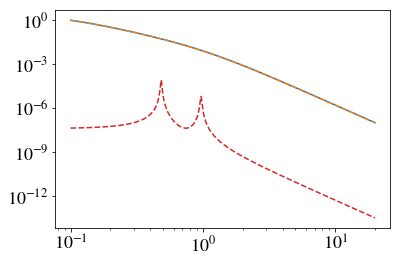

In [25]:
omega = np.exp(np.linspace(np.log(0.1), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.loglog(omega, psd)
for k in gp.kernel.terms:
    plt.loglog(omega, k.get_psd(omega), "--")

In [26]:
mu_int = np.interp(time, x_gp, mu)
var_int = np.interp(time, x_gp, var)
std_int = np.sqrt(var_int)
error_full = np.sqrt((error/median)**2 + var_int)

(1685, 1690)

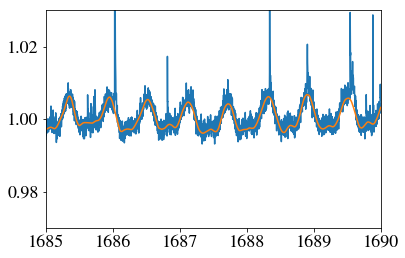

In [27]:
plt.plot(time, flux/median)
plt.plot(time, mu_int)
#plt.xlim(1685, 1688)
plt.ylim(0.97, 1.03)
plt.xlim(1685, 1690)

In [12]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -17.75957880832401),
             ('kernel:terms[0]:log_omega0', -8.473102063956523),
             ('kernel:terms[1]:log_S0', -14.813058110287944),
             ('kernel:terms[1]:log_Q', 0.9518426192530529),
             ('kernel:terms[1]:log_omega0', 2.546071464473513)])

In [13]:
w0 = 10**gp.get_parameter_vector()[-1]
per = 2*np.pi/w0
per

0.01786933554188466

1483.9659005308715 0.012091617656023937 0.08434119609593616


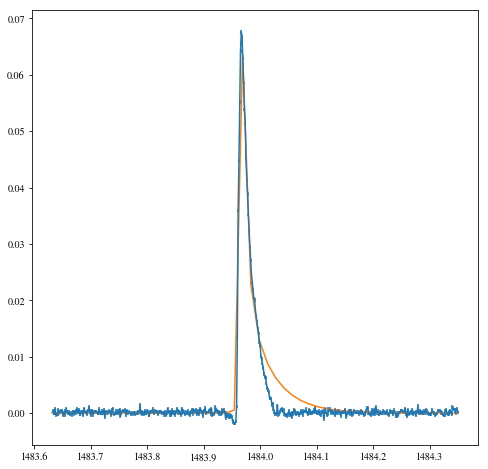

In [57]:
from flareFind import fitFlare
import flareHelpers as fh

x = time
y = flux/median - smo
yerr = error/median

# Search for flares in the smoothed light curve using change point analysis
FL = FINDflare(y, yerr, avg_std=True, std_window=s_window, N1=3, N2=1, N3=3)
for j in range(len(FL[0])):
    s1, s2 = FL[0][j], FL[1][j]+1
    tstart, tstop = x[s1], x[s2]
    dx_fac  = 10
    dx = tstop - tstart
    x1 = tstart - dx*dx_fac/2
    x2 = tstop + dx*dx_fac/2
    mask = (x > x1) & (x < x2)
    
    if (tstart < 1483.75) or (tstart > 1484.25):
        continue

    # Mask out other flare detections when fitting models
    other_mask = np.ones(len(x), dtype=bool)
    for i in range(len(FL[0])):
        s1other, s2other = FL[0][i], FL[1][i]+1
        if i == j:
            continue
        other_mask[s1other:s2other] = 0

    popt1, pstd1, g_chisq, popt2, pstd2, f_chisq, skew, cover = \
        fitFlare(x[other_mask], y[other_mask], yerr[other_mask], x1, x2)

    mu, std, g_amp = popt1[0], popt1[1], popt1[2]
    mu_err, std_err, g_amp_err = pstd1[0], pstd1[1], pstd1[2]

    tpeak, fwhm, f_amp = popt2[0], popt2[1], popt2[2]
    tpeak_err, fwhm_err, f_amp_err = pstd2[0], pstd2[1], pstd2[2]
    
    fig, axes = plt.subplots(figsize=(8,8))
    axes.errorbar(time[mask], flux[mask]/median - smo[mask], error[mask]/median)
    
    xmodel = np.linspace(x1, x2)
    ymodel = fh.aflare1(xmodel, tpeak, fwhm, f_amp)
    print(tpeak, fwhm, f_amp)
    axes.plot(xmodel, ymodel)